In [115]:
import cv2
import sys
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import multiprocessing as mp
import face_recognition
from cvloop import cvloop
import multiprocessing as mp

from keras.models import load_model
from keras.preprocessing.image import load_img,img_to_array

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%matplotlib notebook

In [3]:
train_base_dir='/home/ubuntu/videos/fer_dataset/images_fer2013/Training/'
test_base_dir='/home/ubuntu/videos/fer_dataset/images_fer2013/PrivateTest/'
val_base_dir='/home/ubuntu/videos/fer_dataset/images_fer2013/PublicTest/'

In [4]:
train_angry = os.path.join(train_base_dir,'Angry/')
train_disgust=os.path.join(train_base_dir,'Disgust/')
train_fear=os.path.join(train_base_dir,'Fear/')
train_happy=os.path.join(train_base_dir,'Happy/')
train_neutral=os.path.join(train_base_dir,'Neutral/')
train_sad=os.path.join(train_base_dir,'Sad/')
train_surprise=os.path.join(train_base_dir,'Surprise/')

In [5]:
test_angry = os.path.join(test_base_dir,'Angry/')
test_disgust=os.path.join(test_base_dir,'Disgust/')
test_fear=os.path.join(test_base_dir,'Fear/')
test_happy=os.path.join(test_base_dir,'Happy/')
test_neutral=os.path.join(test_base_dir,'Neutral/')
test_sad=os.path.join(test_base_dir,'Sad/')
test_surprise=os.path.join(test_base_dir,'Surprise/')

In [6]:
val_angry = os.path.join(val_base_dir,'Angry/')
val_disgust=os.path.join(val_base_dir,'Disgust/')
val_fear=os.path.join(val_base_dir,'Fear/')
val_happy=os.path.join(val_base_dir,'Happy/')
val_neutral=os.path.join(val_base_dir,'Neutral/')
val_sad=os.path.join(val_base_dir,'Sad/')
val_surprise=os.path.join(val_base_dir,'Surprise/')

In [7]:
train_subdirs=[train_angry,train_disgust,train_fear,train_happy,train_neutral,train_sad,train_surprise]
test_subdirs=[test_angry,test_disgust,test_fear,test_happy,test_neutral,test_sad,test_surprise]
val_subdirs=[val_angry,val_disgust,val_fear,val_happy,val_neutral,val_sad,val_surprise]


In [8]:
base_dirs=[train_subdirs,test_subdirs,val_subdirs]

In [97]:
for dirs in base_dirs:
    for subdir in dirs:
        print(len(os.listdir(subdir)),end=", ")
    print()

3995, 436, 4097, 7215, 4965, 4830, 3171, 
491, 55, 528, 879, 626, 594, 416, 
467, 56, 496, 895, 607, 653, 415, 


In [88]:
def video_landmarks(frame):
    face_landmarks = face_recognition.face_landmarks(frame)
    print(face_landmarks)
    
    
    for i in face_landmarks:
        for j in list(i.values()):
            pts = np.array(j, np.int32)
            frame = cv2.polylines(frame, [pts], False, (0,255,255), 2)
    
    return frame
def get_face_landmarks(path):
    frame = cv2.imread(path)      
    face_landmarks = face_recognition.face_landmarks(frame)

    return face_landmarks

def get_face_points(d):
    f = [(0,0)] * 20
    f[1] = np.mean(d["left_eye"][1:3], axis=0)
    f[2] = np.mean(d["left_eye"][4:6], axis=0)
    f[3] = d["left_eye"][0]
    f[4] = d["left_eye"][4]
    f[5] = np.mean(d["right_eye"][1:3], axis=0)
    f[6] = np.mean(d["right_eye"][4:6], axis=0)
    f[7] = d["right_eye"][0]
    f[8] = d["right_eye"][4]
    f[9] = d["nose_bridge"][-1]
    f[10] = d["left_eyebrow"][0]
    f[11] = d["left_eyebrow"][-1]
    f[12] = d["left_eyebrow"][2]
    f[13] = d["right_eyebrow"][0]
    f[14] = d["right_eyebrow"][-1]
    f[15] = d["right_eyebrow"][2]
    f[16] = d["top_lip"][0]
    f[17] = d["top_lip"][6]
    f[18] = np.mean((d["top_lip"][9], d["bottom_lip"][9]), axis=0)
    f[19] = d["nose_bridge"][0] 
    return np.array([*f])


def get_vector(face_landmarks):
    if len(face_landmarks) > 0:
        f = get_face_points(face_landmarks)
        v = np.zeros(12, dtype=float)
        
        
        v[0] = abs((f[1] - f[2])[-1])
        v[1] = abs((f[4] - f[3])[0])
        v[2] = abs((f[5] - f[6])[-1])
        v[3] = abs((f[8] - f[7])[0])
        v[4] = abs((f[11] - f[10])[0])
        v[5] = abs((f[14] - f[13])[0])
        v[6] = abs((f[16] - f[17])[0])
        v[7] = round(np.linalg.norm(f[12]-f[1]),2)
        v[8] = round(np.linalg.norm(f[15]-f[5]),2)
        v[9] = round(np.linalg.norm(f[9]-f[18]),2)
        v[10] = round(np.linalg.norm(f[2]-f[16]),2)
        v[11] = round(np.linalg.norm(f[6]-f[17]),2)
        
        return v
   
    return np.nan


def get_features(face_landmarks):
    pool = mp.Pool(8)
    vectors = [pool.apply_async(get_vector, (i,)) for i in face_landmarks]
    vectors = np.array([j.get() for j in vectors])
    pool.close()
    return vectors


# preparing data

In [100]:
face_landmarks_angry=[get_face_landmarks(train_angry+x) for x in os.listdir(train_angry)]
face_landmarks_disgust=[get_face_landmarks(train_disgust+x) for x in os.listdir(train_disgust)]
face_landmarks_fear=[get_face_landmarks(train_fear+x) for x in os.listdir(train_fear)]
face_landmarks_happy=[get_face_landmarks(train_happy+x) for x in os.listdir(train_happy)]
face_landmarks_neutral=[get_face_landmarks(train_neutral+x) for x in os.listdir(train_neutral)]
face_landmarks_sad=[get_face_landmarks(train_sad+x) for x in os.listdir(train_sad)]
face_landmarks_surprise=[get_face_landmarks(train_surprise+x) for x in os.listdir(train_surprise)]

In [120]:
face_landmarks_list = [face_landmarks_angry, face_landmarks_disgust, face_landmarks_fear, face_landmarks_happy,
                  face_landmarks_neutral, face_landmarks_sad, face_landmarks_surprise]

face_landmarks = [[i[0] for i in items if i] for items in face_landmarks_list]

In [122]:
for sub_dir in face_landmarks_list :
    print(len(sub_dir),end=", ")

3995, 436, 4097, 7215, 4965, 4830, 3171, 

In [90]:
features = []
labels =  range(7)

for label, landmarks in list(zip(labels, face_landmarks)):
    vector = get_features(landmarks)
    features.append(vector)

In [91]:
item_labels = [[i]*len(features[i]) for i in labels]

In [92]:
x = np.concatenate(features)
y = np.concatenate(item_labels)

In [102]:
pd.DataFrame(x)

0    1    2    3     4     5     6     7     8      9     10     11
0      2.0  5.0  2.0  5.0  14.0  16.0  15.0  5.22  6.32   9.51  21.01  21.38
1      3.0  4.0  2.5  6.0  14.0  13.0  16.0  6.96  6.67  13.00  22.70  23.05
2      2.5  2.0  3.0  5.0   6.0  14.0  10.0  5.00  5.59  10.31  17.39  18.56
3      3.0  4.0  3.0  5.0  13.0  14.0  11.0  3.91  3.04   6.08  17.36  17.07
4      2.0  3.0  2.0  3.0   8.0  11.0  11.0  4.27  4.12   8.25  14.14  14.04
...    ...  ...  ...  ...   ...   ...   ...   ...   ...    ...    ...    ...
19988  3.0  6.0  3.0  6.0  15.0  13.0  15.0  8.25  7.83  12.54  20.10  20.40
19989  3.0  5.0  3.0  6.0  13.0  14.0  14.0  6.18  5.22   9.50  18.17  19.16
19990  2.5  5.0  2.0  5.0  16.0  11.0  15.0  6.58  7.11  11.40  19.06  17.95
19991  2.5  4.0  3.0  5.0  11.0  10.0  16.0  5.52  5.59   9.00  16.00  15.03
19992  3.5  5.0  3.0  5.0  12.0  13.0  12.0  5.70  6.18   9.50  19.53  19.16

[19993 rows x 12 columns]

In [30]:
x.shape,y.shape

((19993, 12), (19993,))

<IPython.core.display.Javascript object>


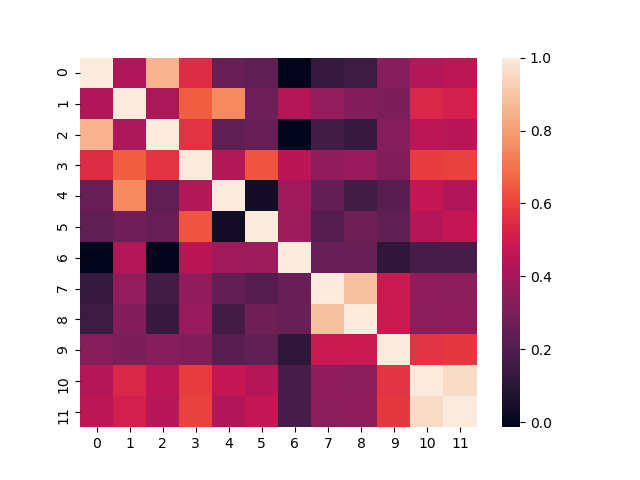

In [31]:
sns.heatmap(pd.DataFrame(x).corr())

In [66]:
pd.DataFrame(x).describe()

0             1             2             3             4   \
count  19993.000000  19993.000000  19993.000000  19993.000000  19993.000000   
mean       2.196994      4.567098      2.212399      5.014755     12.417496   
std        0.826161      0.949828      0.826779      1.015847      2.892275   
min        0.000000      1.000000      0.000000      1.000000      1.000000   
25%        1.500000      4.000000      1.500000      4.000000     11.000000   
50%        2.000000      5.000000      2.000000      5.000000     13.000000   
75%        3.000000      5.000000      3.000000      6.000000     14.000000   
max        6.000000      9.000000      6.000000     10.000000     22.000000   

                 5             6             7             8             9   \
count  19993.000000  19993.000000  19993.000000  19993.000000  19993.000000   
mean      12.660181     14.920772      5.579378      5.643122      9.964121   
std        2.860338      3.153951      1.398813      1.407993      2.239813   
min        1.000000      5.000000      1.120000      1.410000      3.040000   
25%       11.000000     13.000000      4.530000      4.610000      8.500000   
50%       13.000000     15.000000      5.410000      5.520000      9.820000   
75%       14.000000     17.000000      6.500000      6.500000     11.400000   
max       25.000000     31.000000     12.370000     12.170000     21.020000   

                 10            11  
count  19993.000000  19993.000000  
mean      17.750988     17.768229  
std        2.819646      2.842031  
min        9.000000      9.010000  
25%       16.000000     16.010000  
50%       17.720000     17.720000  
75%       19.500000     19.510000  
max       31.080000     32.200000

# Machine Learning Models

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x,y)

In [54]:
class Classifier():
    def __init__(self, clf):
        self.clf = clf
        
    def score(self, x_train, y_train, x_test, y_test):
        self.clf = self.clf.fit(x_train, y_train)
        print("Train Score : %0.2f"%(self.clf.score(x_train, y_train)))
        print("Test Score : %0.2f"%(self.clf.score(x_test, y_test)))
        print("Classification Report")
        print(classification_report(y_test, self.clf.predict(x_test)))
        
        if hasattr(self.clf, "feature_importances_"):
            print("Feature Importance")
            print(np.array(list(zip(range(12), self.clf.feature_importances_))))


In [103]:
clf = RandomForestClassifier()  #max_features=3, max_depth=5
Classifier(clf).score(x_train, y_train, x_test, y_test)

/home/ubuntu/anaconda3/envs/video_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train Score : 0.99
Test Score : 0.50
Classification Report
              precision    recall  f1-score   support

           0       0.33      0.38      0.35       663
           1       0.62      0.20      0.30       100
           2       0.29      0.26      0.28       638
           3       0.69      0.80      0.74      1467
           4       0.39      0.44      0.41       894
           5       0.31      0.19      0.24       638
           6       0.68      0.57      0.62       599

    accuracy                           0.50      4999
   macro avg       0.47      0.41      0.42      4999
weighted avg       0.49      0.50      0.48      4999

Feature Importance
[[ 0.          0.05303802]
 [ 1.          0.03290118]
 [ 2.          0.05371916]
 [ 3.          0.03162365]
 [ 4.          0.07211555]
 [ 5.          0.07247533]
 [ 6.          0.13817104]
 [ 7.          0.09230368]
 [ 8.          0.09516935]
 [ 9.          0.11452474]
 [10.          0.12644023]
 [11.          0.11751807]]


In [56]:
clf = LinearDiscriminantAnalysis()
Classifier(clf).score(x_train, y_train, x_test, y_test)

Train Score : 0.48
Test Score : 0.50
Classification Report
              precision    recall  f1-score   support

           0       0.37      0.43      0.39       663
           1       0.33      0.01      0.02       100
           2       0.27      0.07      0.11       638
           3       0.67      0.86      0.75      1467
           4       0.38      0.52      0.44       894
           5       0.36      0.16      0.22       638
           6       0.52      0.59      0.55       599

    accuracy                           0.50      4999
   macro avg       0.41      0.38      0.36      4999
weighted avg       0.46      0.50      0.46      4999



# Neural Networks

In [57]:
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU, Input, Concatenate, Subtract, LSTM
from keras.utils import to_categorical

In [25]:
y_categ=to_categorical(y)

In [182]:
x_train, x_test, y_train, y_test = train_test_split(x, y_categ, test_size=0.33, random_state=101)

In [109]:
inp = Input((12,))
inpi = -inp
x = Concatenate([inp, inpi])
x = Dense(32)(inp)
x = LeakyReLU(0.5)(x)
x = Dense(32)(x)
x = LeakyReLU(0.5)(x)
out = Dense(7, activation='softmax')(x)

model = Model(inp, out)

In [110]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [111]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                416       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 231       
Total params: 1,703
Trainable params: 1,703
Non-trainable params: 0
_________________________________________________________________


In [112]:
model.fit(x_train,y_train,epochs=200,batch_size=64,validation_data=(x_test,y_test))

Train on 14994 samples, validate on 4999 samples
Epoch 1/200
14994/14994 [==============================] - 1s 43us/step - loss: 1.9698 - acc: 0.3453 - val_loss: 1.5141 - val_acc: 0.4475
Epoch 2/200
14994/14994 [==============================] - 0s 23us/step - loss: 1.4758 - acc: 0.4399 - val_loss: 1.4457 - val_acc: 0.4643
Epoch 3/200
14994/14994 [==============================] - 0s 22us/step - loss: 1.4413 - acc: 0.4591 - val_loss: 1.4318 - val_acc: 0.4589
Epoch 4/200
14994/14994 [==============================] - 0s 22us/step - loss: 1.4306 - acc: 0.4609 - val_loss: 1.4258 - val_acc: 0.4857
Epoch 5/200
14994/14994 [==============================] - 0s 23us/step - loss: 1.4184 - acc: 0.4737 - val_loss: 1.4091 - val_acc: 0.4741
Epoch 6/200
14994/14994 [==============================] - 0s 23us/step - loss: 1.4154 - acc: 0.4675 - val_loss: 1.4186 - val_acc: 0.4757
Epoch 7/200
14994/14994 [==============================] - 0s 22us/step - loss: 1.4132 - acc: 0.4790 - val_loss: 1.3955 - v

Epoch 118/200
14994/14994 [==============================] - 0s 23us/step - loss: 1.3015 - acc: 0.5065 - val_loss: 1.3144 - val_acc: 0.5163
Epoch 119/200
14994/14994 [==============================] - 0s 23us/step - loss: 1.2994 - acc: 0.5071 - val_loss: 1.3165 - val_acc: 0.5121
Epoch 120/200
14994/14994 [==============================] - 0s 22us/step - loss: 1.3036 - acc: 0.5064 - val_loss: 1.3221 - val_acc: 0.5149
Epoch 121/200
14994/14994 [==============================] - 0s 22us/step - loss: 1.3005 - acc: 0.5043 - val_loss: 1.3135 - val_acc: 0.5103
Epoch 122/200
14994/14994 [==============================] - 0s 22us/step - loss: 1.3042 - acc: 0.5079 - val_loss: 1.3179 - val_acc: 0.5173
Epoch 123/200
14994/14994 [==============================] - 0s 23us/step - loss: 1.3028 - acc: 0.5071 - val_loss: 1.3163 - val_acc: 0.5099
Epoch 124/200
14994/14994 [==============================] - 0s 23us/step - loss: 1.2995 - acc: 0.5064 - val_loss: 1.3111 - val_acc: 0.5125
Epoch 125/200
14994/

<IPython.core.display.Javascript object>


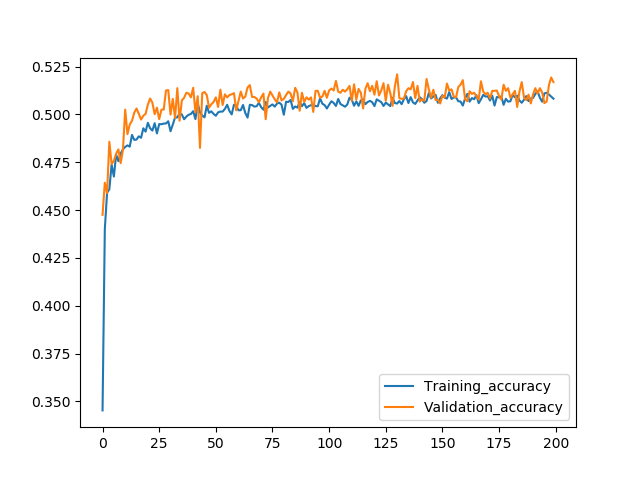

In [117]:
plt.plot(model.history.history.get('acc'))
plt.plot(model.history.history.get('val_acc'))
plt.legend(['Training_accuracy','Validation_accuracy'])

In [123]:
preds=model.predict(x_test)

In [129]:
pred_labels=[pred.argmax() for pred in preds]

In [132]:
print("Classification Report: ")
print(classification_report(y_test, pred_labels))

Classification Report: 
              precision    recall  f1-score   support

           0       0.40      0.38      0.39       663
           1       0.71      0.05      0.09       100
           2       0.27      0.12      0.16       638
           3       0.71      0.83      0.76      1467
           4       0.39      0.63      0.48       894
           5       0.40      0.15      0.22       638
           6       0.56      0.62      0.59       599

    accuracy                           0.52      4999
   macro avg       0.49      0.40      0.39      4999
weighted avg       0.50      0.52      0.48      4999



In [133]:
print("confusion matrix: ")
print(confusion_matrix(y_test,pred_labels))

confusion matrix: 
[[ 255    1   39   98  199   26   45]
 [  35    5    8   12   22   12    6]
 [ 111    0   75  108  192   34  118]
 [  28    0   32 1220  140   22   25]
 [  80    0   41  109  563   47   54]
 [ 104    0   36  103  259   96   40]
 [  31    1   50   79   64    4  370]]


In [118]:
model.save('emotion_detection_with_landmarks_distance_based_model1.h5')